# Model 4



In [102]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from geopy.distance import geodesic
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [103]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Trav_3_data_Final.xlsx')

df_copy = df.copy()

df_trav1 = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/model4_full.xlsx')

df_2 = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/model4_full.xlsx')

df_full = df_2.copy()

In [104]:
# define an element dictionary
from scipy.spatial import cKDTree

elements = {'Na_mM_EC', 'Ca_mM_EC', 'Mg_mM_EC', 'Si_mM_EC', 'K_mM_EC', 'Al_mM_EC'}

# make copies of elements Na_uM_EC etc

# Convert to μM and save as new columns
for elem in elements:
    new_col = elem.replace('_mM_', '_uM_')  # Replace 'mM' with 'uM' in the column name
    df_copy[new_col] = df_copy[elem] * 1000  # Convert mM to μM
    df_full[new_col] = df_full[elem] * 1000  # Convert mM to μM
    df_trav1[new_col] = df_trav1[elem] * 1000  # Convert mM to μM


elements_micro = {'Na_uM_EC', 'Ca_uM_EC', 'Mg_uM_EC', 'Si_uM_EC', 'K_uM_EC', 'Al_uM_EC'}

df_traverse3 = df_copy[df_copy['Traverse'] == 'Traverse 3']

df_traverse1 = df_trav1[df_trav1['Traverse'] == 'Traverse 1']


# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_0 = {element: df_traverse3[element].min() for element in elements_micro}

C_0 = {element: df_traverse1[element].min() for element in elements_micro}


for element in elements_micro:
    df_traverse3[f'C_0_{element}'] = C_0[element]
    df_traverse1[f'C_0_{element}'] = C_0[element]
    


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2174900569.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'C_0_{element}'] = C_0[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2174900569.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'C_0_{element}'] = C_0[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2174900569.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [105]:
# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_eq = {element: df_full[element].max() for element in elements_micro}

for element in elements_micro:
    df_traverse3[f'C_eq_{element}'] = C_eq[element]
    df_traverse1[f'C_eq_{element}'] = C_eq[element]

# print the first 5 rows of C_eq_element
print(df_traverse3[[f'C_eq_{element}' for element in elements_micro]].head())



   C_eq_Na_uM_EC  C_eq_Ca_uM_EC  C_eq_Al_uM_EC  C_eq_Si_uM_EC  C_eq_Mg_uM_EC  \
0      501.88711     960.514077      16.204954     869.214435     163.835453   
1      501.88711     960.514077      16.204954     869.214435     163.835453   
2      501.88711     960.514077      16.204954     869.214435     163.835453   
3      501.88711     960.514077      16.204954     869.214435     163.835453   
4      501.88711     960.514077      16.204954     869.214435     163.835453   

   C_eq_K_uM_EC  
0    185.855325  
1    185.855325  
2    185.855325  
3    185.855325  
4    185.855325  


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/1192495098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'C_eq_{element}'] = C_eq[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/1192495098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'C_eq_{element}'] = C_eq[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/1192495098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

# Maher


In [106]:
A_a = 0.1  # Specific surface area (m^2/g)

X_r = 0.2  # Mineral concentration in rock (unitless, g/g)

rho_sf = 2.7 * 1000 * 1000  # Mass mineral / fluid volume ratio (g/cm^3), assuming porosity = 0.1 [for now]

k = 10**(-15) # Reaction rate (mol/m^2/s)

R_n = rho_sf * A_a * k * X_r # Rate constant (mol/m^2/s)

print(R_n)

5.4e-11


In [107]:
def calculate_T_res_Model4_Maher(C, C_0, C_eq, R_n):

    # how to write e**2 in python?
    e2 = np.exp(2)

    T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
    
    if isinstance(T_res, (list, tuple, np.ndarray)):
        T_res = T_res[0]  # Extract the first value if it's an array

    if not np.isscalar(T_res) or np.isnan(T_res):
        return np.nan  # Ensure we return a single number

    T_res_yr = T_res * 10**(-3) / 31557600 # Convert seconds to years
    
    
    return float(T_res_yr)  # Ensure it's a float

# Apply calculation to each element in df_traverse3
for element in elements_micro:
    col_name = f'T_res_Maher_{element}'
    df_traverse3[f'T_res_Maher_{element}'] = df_traverse3.apply(
        lambda row: calculate_T_res_Model4_Maher(
            row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'],
            R_n
        ), axis=1
    )
    
    df_traverse1[f'T_res_Maher_{element}'] = df_traverse1.apply(
        lambda row: calculate_T_res_Model4_Maher(
            row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'],
            R_n
        ), axis=1
    )



/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2168788261.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2168788261.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'T_res_Maher_{element}'] = df_traverse1.apply(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2168788261.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2168788261.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [108]:
# def calculate_k_Model4_Maher(C, C_0, C_eq):

#     # how to write e**2 in python?
#     e2 = np.exp(2)
    
#     T_res_k = 10 * 31557600 * 10**3 # 10 years in 10^-6 seconds
    
#     # Make T_res_k go between 0.5 and 10 years between MKS-5 and MKS-9 exponentially eg e^-kt

#     k_end = (C_eq * (C - C_0)) / (e2 * (C_eq - C)* T_res_k * rho_sf * A_a * X_r)
    
#     if isinstance(k_end, (list, tuple, np.ndarray)):
#         k_end = k_end[0]  # Extract the first value if it's an array

#     if not np.isscalar(k_end) or np.isnan(k_end):
#         return np.nan  # Ensure we return a single number

#     return float(k_end)  # Ensure it's a float

# # Apply calculation only for the row where 'Sample ID' is "NEP22-45"
# for element in elements_micro:
#     col_name = f'k_end_Maher_{element}'
#     df_traverse3.loc[df_traverse3['Sample ID'] == "NEP22-45", col_name] = df_traverse3.loc[
#         df_traverse3['Sample ID'] == "NEP22-45"
#     ].apply(
#         lambda row: calculate_k_Model4_Maher(
#             row[element], row[f'C_0_{element}'], row[f'C_eq_{element}']), axis=1
#     )


# # Also do it for Sample IDs df_copy['Sample ID'] == 'MKS-5', 'MKS-6', 'MKS75', 'MKS-8', 'MKS-9',


In [109]:
# import numpy as np

# def calculate_k_Model4_Maher(C, C_0, C_eq, T_res_k):
#     # Compute e^2 in Python
#     e2 = np.exp(2)
    
#     # k_end calculation
#     k_end = (C_eq * (C - C_0)) / (e2 * (C_eq - C) * T_res_k * rho_sf * A_a * X_r)
    
#     if isinstance(k_end, (list, tuple, np.ndarray)):
#         k_end = k_end[0]  # Extract the first value if it's an array

#     if not np.isscalar(k_end) or np.isnan(k_end):
#         return np.nan  # Ensure we return a single number

#     return float(k_end)  # Ensure it's a float

# # Sample IDs to process
# target_samples = ['NEP22-10', 'NEP22-19', 'NEP22-55', 'NEP22-56', 'NEP22-45']

# # Define T_res_k values increasing linearly between 0.5 and 10 years
# T_min = 0.5 * 31557600 * 10**3 # 0.5 years in seconds
# T_max = 10 * 31557600 * 10**3  # 10 years in seconds
# sample_tres_mapping = {
#     "NEP22-10": T_min,
#     "NEP22-19": T_min + (T_max - T_min) * 0.25,
#     "NEP22-55": T_min + (T_max - T_min) * 0.50,
#     "NEP22-56": T_min + (T_max - T_min) * 0.75,
#     "NEP22-45": T_max
# }

# # Apply calculation only for selected Sample IDs
# for element in elements_micro:
#     col_name = f'k_end_Maher_{element}'
    
#     for sample_id in target_samples:
#         T_res_k = sample_tres_mapping.get(sample_id, T_max)  # Use T_max for "NEP22-45"
        
#         df_traverse3.loc[df_traverse3['Sample ID'] == sample_id, col_name] = df_traverse3.loc[
#             df_traverse3['Sample ID'] == sample_id
#         ].apply(
#             lambda row: calculate_k_Model4_Maher(
#                 row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'], T_res_k
#             ), axis=1
#         )


In [110]:
print("T_res Range for Each Element:")
for element in elements_micro:
    col_name = f'T_res_Maher_{element}'
    
    # Drop NaNs and ensure the column is numeric
    T_res_Maher_series = pd.to_numeric(df_traverse3[col_name], errors='coerce').dropna()

    if not T_res_Maher_series.empty:
        T_res_min = T_res_Maher_series.min()
        T_res_max = T_res_Maher_series.max()
        print(f"Element: {element}, T_res range: {T_res_min:.2f} to {T_res_max:.2f} years")
    else:
        print(f"Element: {element}, No valid T_res values available")


for element in elements_micro:
    col_name = f'T_res_Maher_{element}'
    
    # Drop NaNs and ensure the column is numeric
    T_res_Maher_series_trav1 = pd.to_numeric(df_traverse1[col_name], errors='coerce').dropna()
    
    # remove all sample times greater than 1000 years
    T_res_Maher_series_trav1 = T_res_Maher_series_trav1[T_res_Maher_series_trav1 < 1000]
    if not T_res_Maher_series_trav1.empty:
        T_res_min = T_res_Maher_series_trav1.min()
        T_res_max = T_res_Maher_series_trav1.max()
        print(f"Element: {element}, T_res range: {T_res_min:.2f} to {T_res_max:.2f} years")
    else:
        print(f"Element: {element}, No valid T_res values available")

T_res Range for Each Element:
Element: Na_uM_EC, T_res range: -12.77 to 13.00 years
Element: Ca_uM_EC, T_res range: -2.21 to 8.51 years
Element: Al_uM_EC, T_res range: -0.03 to 0.05 years
Element: Si_uM_EC, T_res range: -9.70 to 38.34 years
Element: Mg_uM_EC, T_res range: -0.32 to 1.45 years
Element: K_uM_EC, T_res range: -0.40 to 1.53 years
Element: Na_uM_EC, T_res range: 0.00 to 244.75 years
Element: Ca_uM_EC, T_res range: 0.00 to 232.94 years
Element: Al_uM_EC, T_res range: 0.00 to 0.05 years
Element: Si_uM_EC, T_res range: 0.00 to 544.90 years
Element: Mg_uM_EC, T_res range: 0.00 to 222.05 years
Element: K_uM_EC, T_res range: 0.00 to 13.08 years


In [111]:
# Convert all T_res columns to numeric to avoid errors
for element in elements_micro:
    df_traverse3[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse3[f"T_res_Maher_{element}"], errors='coerce')
    df_traverse1[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Maher_{element}"], errors='coerce')

# Determine the number of elements
num_elements = len(elements_micro)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()



# Loop over each element and plot in a separate subplot
for ax, element in zip(axes, elements_micro):
    ax.scatter(df_traverse3["Elevation"], df_traverse3[f"T_res_Maher_{element}"], alpha=0.7, label=f"T_res_MaherTrav3_{element}")
    ax.scatter(df_traverse1["Elevation"], df_traverse1[f"T_res_Maher_{element}"], alpha=0.7, label=f"T_res_MaherTrav1_{element}")
    #ax.set_xlabel("Elevation (m)")
    ax.set_ylabel(f"T_res_Maher_{element} (years)")
    ax.set_title(f"T_res vs Elevation for {element}")
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for i in range(num_elements, len(axes)):
    fig.delaxes(axes[i])

# Set common x-axis label
axes[-1].set_xlabel("Elevation (m)")

# Adjust layout
plt.tight_layout()
#plt.show()
plt.close()


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/1963622880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Maher_{element}"], errors='coerce')


# Fontorbe


In [112]:
S = 0.1  # Specific surface area (m^2/g)

X_r = 0.2  # Mineral concentration in rock (unitless, g/g)

rho_plag = 2.7 * 1000 * 1000 #g/m^3

k = 10**(-15) # Reaction rate (mol/m^2/s)

phi = 0.1

R_n_Fontorbe = k * S * rho_plag * X_r  # Rate constant (mol/m^2/s)

f = 0.5

print(f"Rate constant R_n_Fontorbe: {R_n_Fontorbe:.2e} mol/m^2/s")


Rate constant R_n_Fontorbe: 5.40e-11 mol/m^2/s


In [113]:
def calculate_T_res_Model4_Fontorbe(C, C_0, R_n_Fontorbe):


    T_res = (C - C_0) * phi / ((1-f) * R_n_Fontorbe )
    
    if isinstance(T_res, (list, tuple, np.ndarray)):
        T_res = T_res[0]  # Extract the first value if it's an array

    if not np.isscalar(T_res) or np.isnan(T_res):
        return np.nan  # Ensure we return a single number

    T_res_yr = T_res * 10**(-3) / 31557600 # Convert seconds to years
    
    
    return float(T_res_yr)  # Ensure it's a float

# Apply calculation to each element in df_traverse3
for element in elements_micro:
    col_name = f'T_res_Fontorbe_{element}'
    df_traverse3[f'T_res_Fontorbe_{element}'] = df_traverse3.apply(
        lambda row: calculate_T_res_Model4_Fontorbe(
            row[element], row[f'C_0_{element}'],
            R_n_Fontorbe
        ), axis=1
    )
    
    df_traverse1[f'T_res_Fontorbe_{element}'] = df_traverse1.apply(
        lambda row: calculate_T_res_Model4_Fontorbe(
            row[element], row[f'C_0_{element}'],
            R_n_Fontorbe
        ), axis=1
    )



/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2942969981.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'T_res_Fontorbe_{element}'] = df_traverse1.apply(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2942969981.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'T_res_Fontorbe_{element}'] = df_traverse1.apply(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2942969981.py:27: SettingWithCopyWarning: 
A value is trying 

In [114]:
print("T_res Range for Each Element:")
for element in elements_micro:
    col_name = f'T_res_Fontorbe_{element}'

    # Drop NaNs and ensure the column is numeric
    T_res_Fontorbe_series = pd.to_numeric(df_traverse3[col_name], errors='coerce').dropna()

    if not T_res_Fontorbe_series.empty:
        T_res_min = T_res_Fontorbe_series.min()
        T_res_max = T_res_Fontorbe_series.max()
        print(f"Element: {element}, T_res range: {T_res_min} to {T_res_max} years")
    else:
        print(f"Element: {element}, No valid T_res values available")
        
    
print("T_res Range for Each Element:")
for element in elements_micro:
    col_name = f'T_res_Fontorbe_{element}'

    # Drop NaNs and ensure the column is numeric
    T_res_Fontorbe_series_trav1 = pd.to_numeric(df_traverse1[col_name], errors='coerce').dropna()

    if not T_res_Fontorbe_series.empty:
        T_res_min = T_res_Fontorbe_series_trav1.min()
        T_res_max = T_res_Fontorbe_series_trav1.max()
        print(f"Element: {element}, T_res range: {T_res_min} to {T_res_max} years")
    else:
        print(f"Element: {element}, No valid T_res values available")
        
    

T_res Range for Each Element:
Element: Na_uM_EC, T_res range: -18.3810765327831 to 9.58477265082511 years
Element: Ca_uM_EC, T_res range: -3.286291381713002 to 11.04252186668709 years
Element: Al_uM_EC, T_res range: -0.0443856023840192 to 0.07555931331600271 years
Element: Si_uM_EC, T_res range: -12.878517153110558 to 28.1402991973551 years
Element: Mg_uM_EC, T_res range: -0.4694000938056318 to 1.8455062815856125 years
Element: K_uM_EC, T_res range: -0.5875045584410445 to 1.971273898244651 years
T_res Range for Each Element:
Element: Na_uM_EC, T_res range: 0.0 to 38.97206428082829 years
Element: Ca_uM_EC, T_res range: 0.0 to 110.03785592408477 years
Element: Al_uM_EC, T_res range: 0.0 to 0.07588435021697179 years
Element: Si_uM_EC, T_res range: 0.0 to 78.80232385473848 years
Element: Mg_uM_EC, T_res range: 0.0 to 18.37110998498936 years
Element: K_uM_EC, T_res range: 0.0 to 9.871179759458341 years


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/2327185393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Fontorbe_{element}"], errors='coerce')


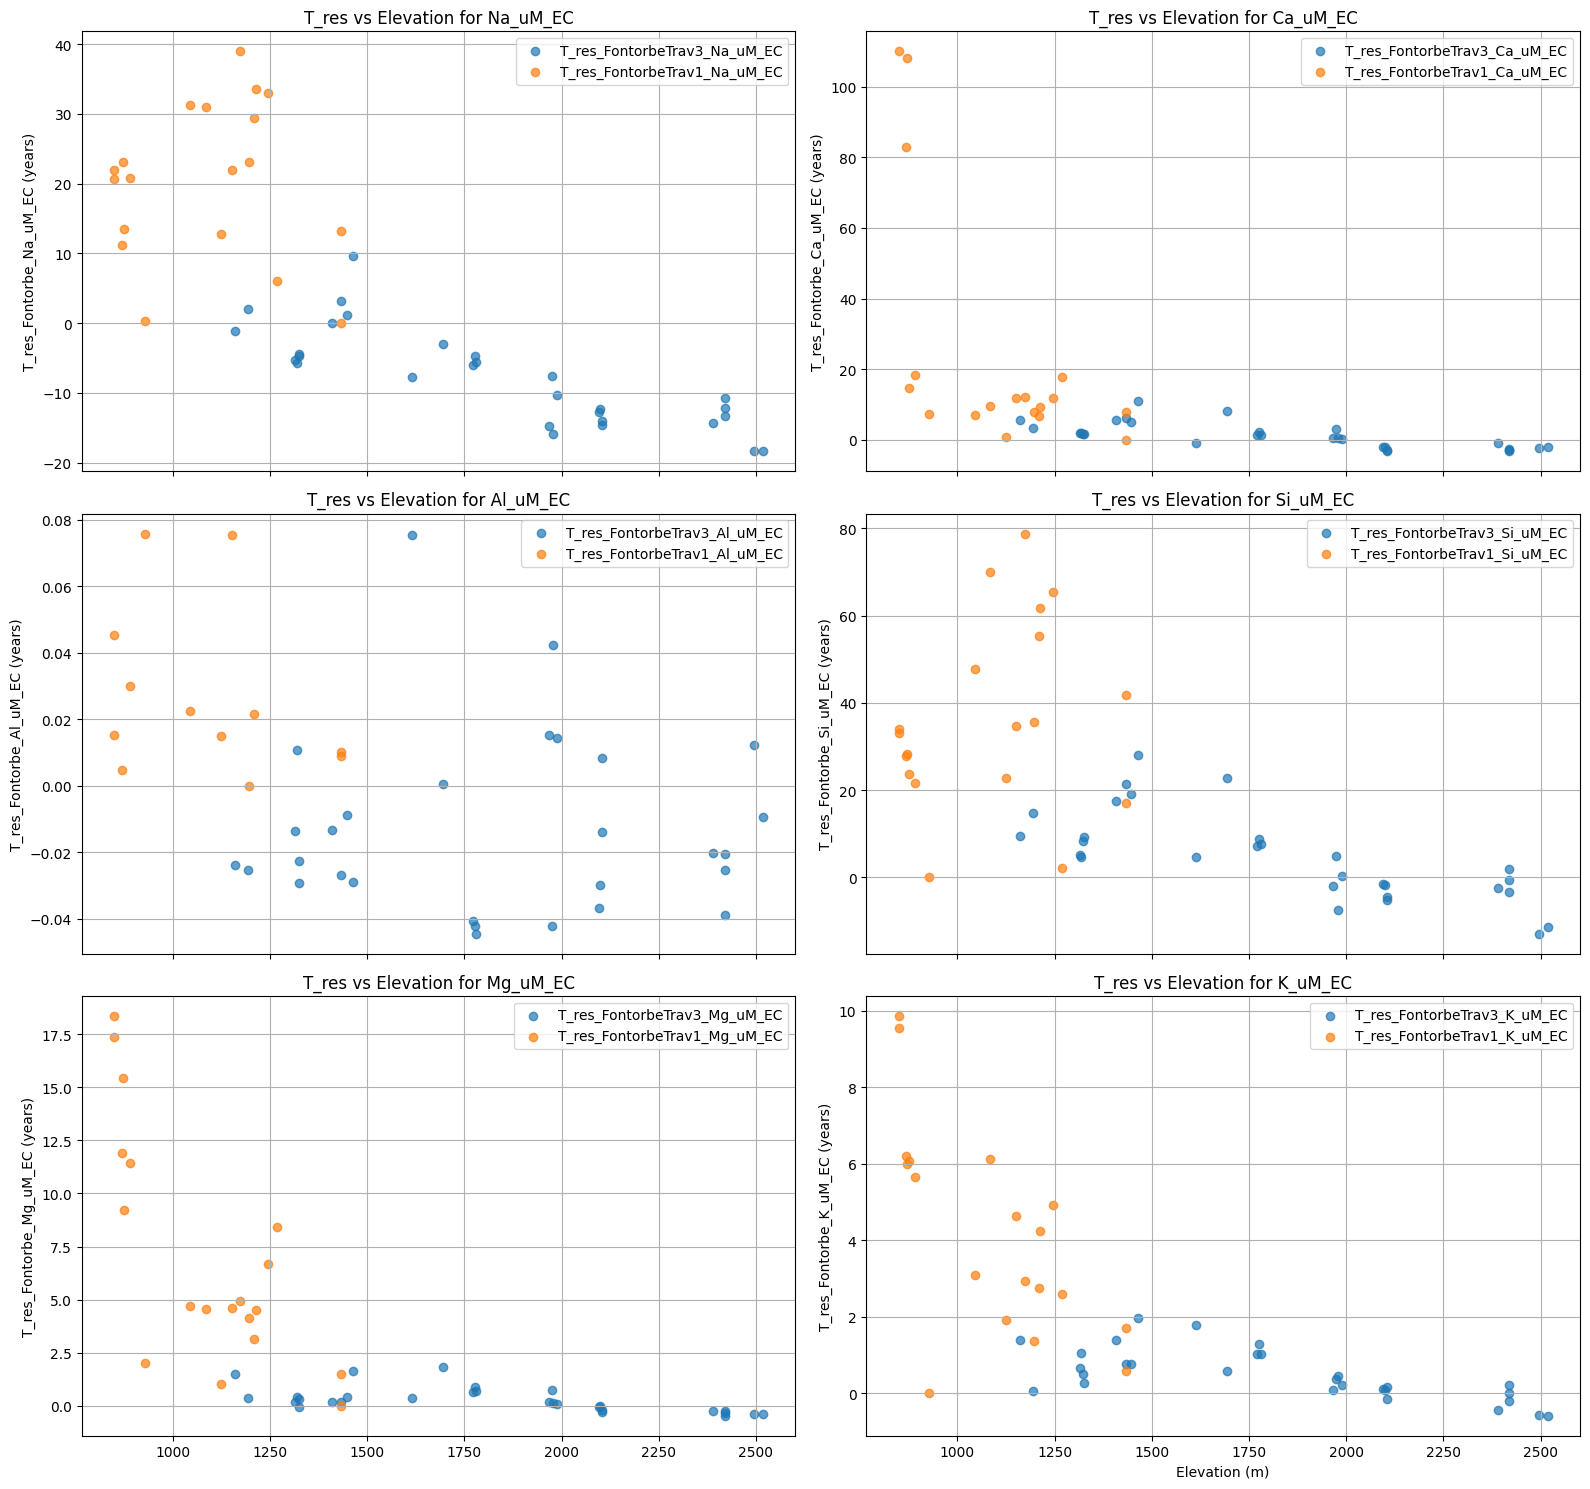

In [115]:
# Convert all T_res columns to numeric to avoid errors
for element in elements_micro:
    df_traverse3[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse3[f"T_res_Fontorbe_{element}"], errors='coerce')
    df_traverse1[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Fontorbe_{element}"], errors='coerce')

# Determine the number of elements
num_elements = len(elements_micro)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each element and plot in a separate subplot
for ax, element in zip(axes, elements_micro):
    ax.scatter(df_traverse3["Elevation"], df_traverse3[f"T_res_Fontorbe_{element}"], alpha=0.7, label=f"T_res_FontorbeTrav3_{element}")
    ax.scatter(df_traverse1["Elevation"], df_traverse1[f"T_res_Fontorbe_{element}"], alpha=0.7, label=f"T_res_FontorbeTrav1_{element}")
    #ax.set_xlabel("Elevation (m)")
    ax.set_ylabel(f"T_res_Fontorbe_{element} (years)")
    ax.set_title(f"T_res vs Elevation for {element}")
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for i in range(num_elements, len(axes)):
    fig.delaxes(axes[i])

# Set common x-axis label
axes[-1].set_xlabel("Elevation (m)")

# Adjust layout
plt.tight_layout()
plt.show()

plt.close()


# Comparison

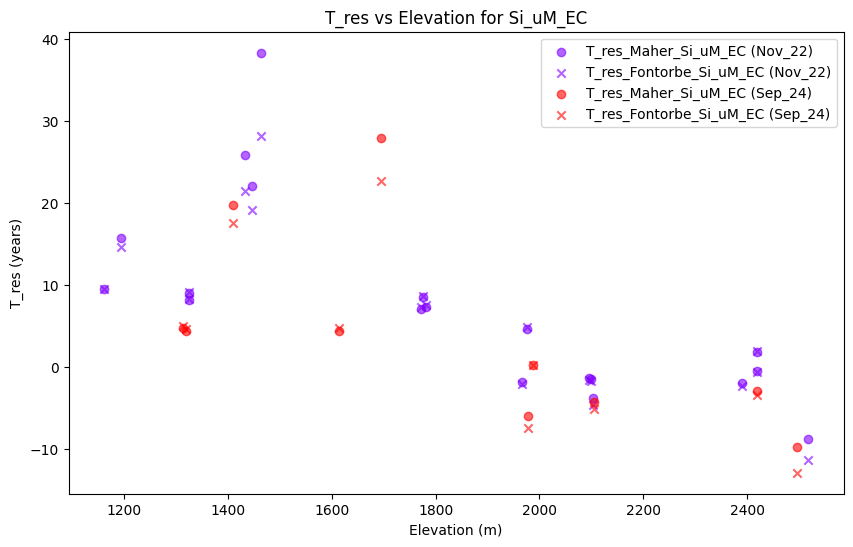

In [116]:
plt.figure(figsize=(10, 6))

# Plot the data
seasons = df_traverse3['Season'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(seasons)))

for season, color in zip(seasons, colors):
    mask = df_traverse3['Season'] == season
    plt.scatter(df_traverse3[mask]['Elevation'], df_traverse3[mask]['T_res_Maher_Si_uM_EC'], label=f'T_res_Maher_Si_uM_EC ({season})', color=color, alpha=0.6)
    plt.scatter(df_traverse3[mask]['Elevation'], df_traverse3[mask]['T_res_Fontorbe_Si_uM_EC'], label=f'T_res_Fontorbe_Si_uM_EC ({season})', color=color, marker='x', alpha=0.6)
    

plt.xlabel('Elevation (m)')
plt.ylabel('T_res (years)')

plt.title('T_res vs Elevation for Si_uM_EC')

# Add a legend
plt.legend()
#plt.yscale('log')
# Display the plot
plt.savefig('T_res_Si_uM_EC_comparison.pdf')   
plt.show()




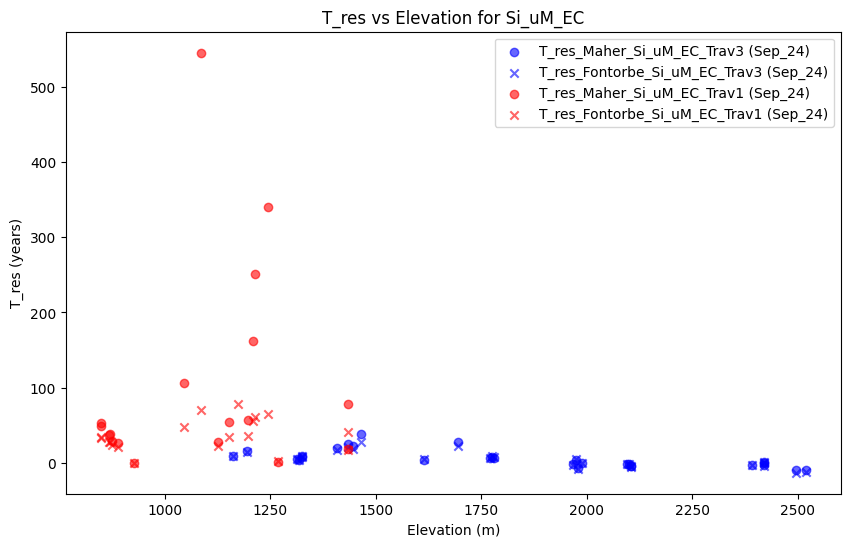

In [117]:
plt.figure(figsize=(10, 6))

# Plot the data
seasons = df_traverse3['Season'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(seasons)))

# filter out df_traverse1 samples greater than 100 years
#df_traverse1 = df_traverse1[df_traverse1['T_res_Maher_Si_uM_EC'] < 100]

plt.scatter(df_traverse3['Elevation'], df_traverse3['T_res_Maher_Si_uM_EC'], label=f'T_res_Maher_Si_uM_EC_Trav3 ({season})', color='blue', alpha=0.6)
plt.scatter(df_traverse3['Elevation'], df_traverse3['T_res_Fontorbe_Si_uM_EC'], label=f'T_res_Fontorbe_Si_uM_EC_Trav3 ({season})', color='blue', marker='x', alpha=0.6)

plt.scatter(df_traverse1['Elevation'], df_traverse1['T_res_Maher_Si_uM_EC'], label=f'T_res_Maher_Si_uM_EC_Trav1 ({season})', color='red', alpha=0.6)
plt.scatter(df_traverse1['Elevation'], df_traverse1['T_res_Fontorbe_Si_uM_EC'], label=f'T_res_Fontorbe_Si_uM_EC_Trav1 ({season})', color='red', marker='x', alpha=0.6)


plt.xlabel('Elevation (m)')
plt.ylabel('T_res (years)')

plt.title('T_res vs Elevation for Si_uM_EC')

# Add a legend
plt.legend()
#plt.yscale('log')
# Display the plot
plt.savefig('T_res_Si_uM_EC_comparison_trav1.pdf')   
plt.show()




# Calculating Delta G


In [118]:
# Delta G_R at standard temp and pressure

T = 273 + 25

R = 8.314

ln_k = 5.58

delta_G_R_0 = -R * T * ln_k

print(f"Delta G_R at standard temp and pressure: {delta_G_R_0:.2f} J/mol")

Delta G_R at standard temp and pressure: -13824.85 J/mol


In [119]:
# calculate concentrations of df_traverse3 in mol/L

df_traverse3['Si_mol_L'] = df_traverse3['Si_uM_EC'] * 10**(-6)
df_traverse3['Na_mol_L'] = df_traverse3['Na_uM_EC'] * 10**(-6)
df_traverse3['Ca_mol_L'] = df_traverse3['Ca_uM_EC'] * 10**(-6)


# calculate delta G_R for each element

# deltaG_r = deltaG_R_0 + R*T*ln(Q)

df_traverse3['Q'] = df_traverse3['Si_mol_L']**1.6 * df_traverse3['Na_mol_L']**0.8 * df_traverse3['Ca_mol_L']**0.2

df_traverse3['delta_G_R'] = delta_G_R_0 + R * T * np.log(df_traverse3['Q'])

df_traverse3['delta_G_R_kJmol'] = df_traverse3['delta_G_R'] / 1000


In [120]:
# calculate concentrations of df_traverse1 in mol/L
df_traverse1['Si_mol_L'] = df_traverse1['Si_uM_EC'] * 10**(-6)
df_traverse1['Na_mol_L'] = df_traverse1['Na_uM_EC'] * 10**(-6)
df_traverse1['Ca_mol_L'] = df_traverse1['Ca_uM_EC'] * 10**(-6)

# calculate delta G_R for each element
df_traverse1['Q'] = df_traverse1['Si_mol_L']**1.6 * df_traverse1['Na_mol_L']**0.8 * df_traverse1['Ca_mol_L']**0.2
df_traverse1['delta_G_R'] = delta_G_R_0 + R * T * np.log(df_traverse1['Q'])
df_traverse1['delta_G_R_kJmol'] = df_traverse1['delta_G_R'] / 1000


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/1024629399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1['Si_mol_L'] = df_traverse1['Si_uM_EC'] * 10**(-6)
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/1024629399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1['Na_mol_L'] = df_traverse1['Na_uM_EC'] * 10**(-6)
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_37423/1024629399.py:4: SettingWithCopyWarning: 
A value is trying to be

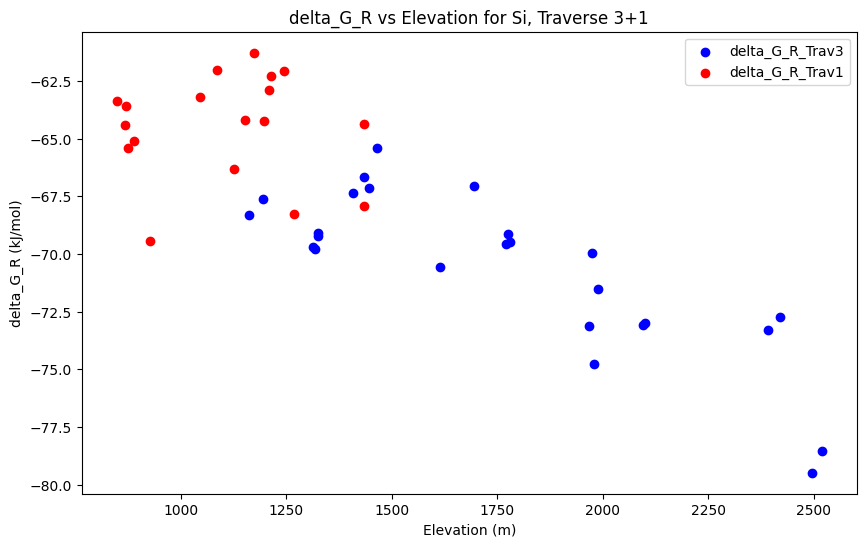

In [121]:
# plot delta_G_R vs Elevation for Si

plt.figure(figsize=(10, 6))

# Plot the data

plt.scatter(df_traverse3['Elevation'], df_traverse3['delta_G_R_kJmol'], label='delta_G_R_Trav3', color = 'blue')
plt.scatter(df_traverse1['Elevation'], df_traverse1['delta_G_R_kJmol'], label='delta_G_R_Trav1', color = 'red')


# Add labels and title
plt.xlabel('Elevation (m)')
plt.ylabel('delta_G_R (kJ/mol)')

plt.title('delta_G_R vs Elevation for Si, Traverse 3+1')

# Add a legend

plt.legend()
#plt.yscale('log')

# Display the plot
plt.savefig('delta_G_R_Si_comparison_Trav1.pdf')


plt.show()

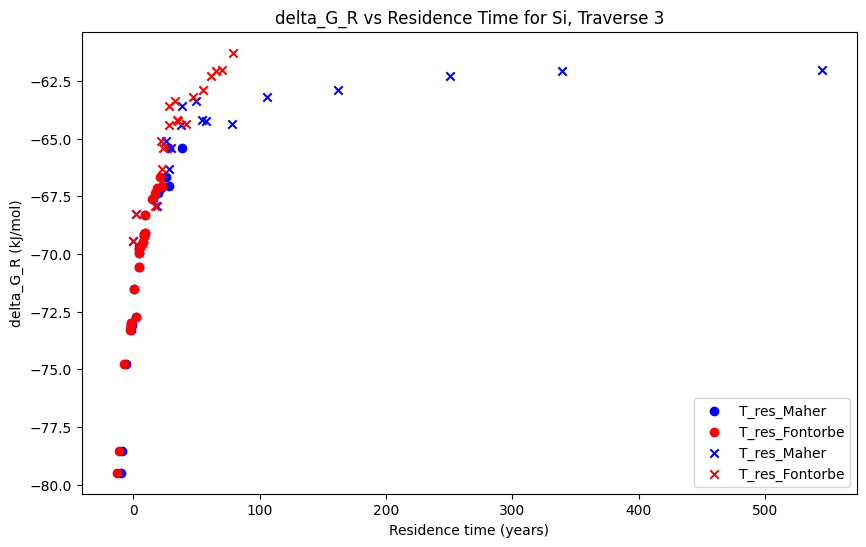

In [122]:
# plot delta_G_R vs Elevation for Si

plt.figure(figsize=(10, 6))

# Plot the data

plt.scatter(df_traverse3['T_res_Maher_Si_uM_EC'], df_traverse3['delta_G_R_kJmol'], color = 'blue', label = 'T_res_Maher')
plt.scatter(df_traverse3['T_res_Fontorbe_Si_uM_EC'], df_traverse3['delta_G_R_kJmol'], color = 'red', label = 'T_res_Fontorbe')

plt.scatter(df_traverse1['T_res_Maher_Si_uM_EC'], df_traverse1['delta_G_R_kJmol'], color = 'blue', marker = 'x', label = 'T_res_Maher')
plt.scatter(df_traverse1['T_res_Fontorbe_Si_uM_EC'], df_traverse1['delta_G_R_kJmol'], color = 'red', marker = 'x', label = 'T_res_Fontorbe')



# Add labels and title
plt.xlabel('Residence time (years)')
plt.ylabel('delta_G_R (kJ/mol)')

plt.title('delta_G_R vs Residence Time for Si, Traverse 3')

# Add a legend

plt.legend()
#plt.yscale('log')


# Display the plot
plt.savefig('delta_G_R_Si_time_trav1.pdf')


plt.show()